## Notebook justification

These series of notebooks are realized during the research performed for our MSc thesis in Astrophysics from the University of Copenhagen and the Niels Bohr Institute (NBI).

## In this notebook we show the results of the machine learning models we trained for quasar classification using data only from the SDSS all-sky survey. 

The data are queried from Sloan Digital Sky Survey using the latest at the time (2022) SDSS DR16 catalogue. We queried approximately 750.000 quasar observations spectroscopically classified as such.

The features used for the training are: Telescope Broad-Band Filter magnitudes: <b>Ultraviolet (u), Green (g), Red (r), Infrared (i and z)</b>. So in total 5 features. We have also included as features the subtractions between the magnitudes, i.e. the colors <b>(u-g, u-r, u-i, u-z, g-r, g-i, g-z, r-i, r-z, i-z)</b>

#### Authors:

      • Marina Koukouvaou • Yannis Mageiras
      
     
#### Date:

      • 29/11/2022



<figure title="Quasar" style="display: inline-block;">
    <img style="margin-left: 150px;" src="./black_hole_accretion_disk.jpg" width="55%"  style="display:inline;">
    <img style="display: left;" src="./galaxy.jpg" width="46%" style="display:inline;">
    <img style="display: right margin-right: 4px;;" src="./star.png" width="40%" style="display:inline;">
    <figcaption style="font-family:Arial;color:gray; font-size:18px;"><br>Top: Artwork showing the very center of an active galaxy, i.e. a quasar. It is depicted a black hole with an accretion disk and magnetic fields swirling above it. Credit: NASA/JPL-Caltech.
<br>
<br>Bottom left: NGC4826 - a spiral galaxy located 17 million light-years away in the constellation of Coma Berenices. This galaxy is often referred to as the "Evil eye" because of the dark band of dust that sweeps across one side of its bright nuvleus. Credit: ESA/Hubble and NASA, J. Lee and the PHANGS-HST Team.
<br>
<br>Bottom right: Artwork of a stellar object. Credit: Pr3t3nd3r / Getty.
Acknowledgement: Judy Schmidt</figcaption>
</figure>

In [1]:
## Importing important libraries for προψεσσινγ, cleaning and visualizing the data 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
import sys

## Importing machine learning libraries
from sklearn.decomposition import PCA 
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## for saving and loading the models
import pickle

#### Importing the data

In [79]:
star_sdss= pd.read_csv("./stars_new.csv")
qso_sdss =pd.read_csv("./qsos_new.csv")
gal_sdss = pd.read_csv("./galaxy_sdss.csv")

### Creating a column with the true class values (0:stars,1:quasars,2:galaxies)
star_sdss['truth'] = 0
star_sdss["label_sns"] = "STAR"

qso_sdss['truth'] = 1 
qso_sdss["label_sns"] = "QSO"

gal_sdss['truth'] = 2
gal_sdss["label_sns"] = "GALAXY"


## First we are exploring the 2 class problem. The classification between quasars and stars.

In [80]:
## Concatenating the data for the 2 class problem (stars and quasars) and the 3 class problem (stars, quasars and galaxies)
data_sdss = pd.concat([qso_sdss,star_sdss], axis = 0, ignore_index = True).reset_index(drop = True) 
data_sdss_3class = pd.concat([qso_sdss,star_sdss,gal_sdss], axis = 0, ignore_index = True).reset_index(drop = True) 

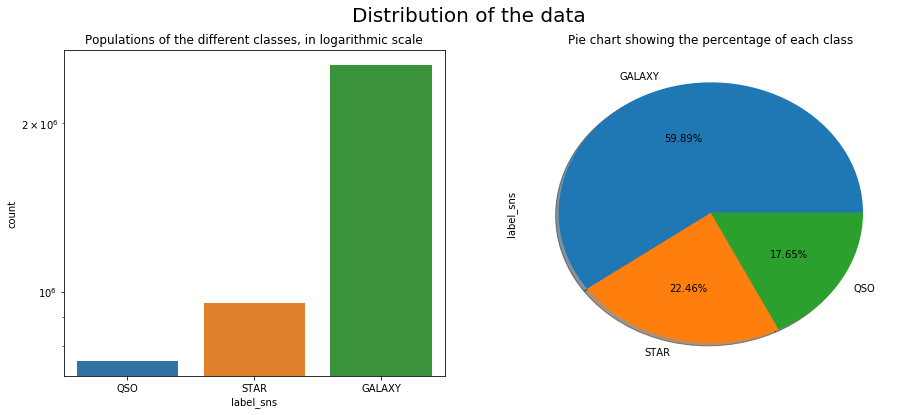

The exact populations are:


GALAXY    2548984
STAR       956010
QSO        751160
Name: label_sns, dtype: int64

In [81]:
fig, ax = plt.subplots(1,2, figsize=(15,6)) 
fig.suptitle('Distribution of the data', fontsize=20)

ax[0]=sns.countplot(x=data_sdss_3class['label_sns'], ax=ax[0])
ax[0].set_title('Populations of the different classes, in logarithmic scale')
ax[0].set_yscale('log')

ax[1]=data_sdss_3class['label_sns'].value_counts().plot.pie(y='class',autopct='%1.2f%%',shadow=True)
ax[1].set_title('Pie chart showing the percentage of each class')
plt.show()

print('The exact populations are:')
data_sdss_3class['label_sns'].value_counts()

#### As can be seen from the plot above the dataset is highly imbalanced. First we will show the performance of the model on this unbalanced set and later we will equalize the data down to the class with the smallest size and pin point the differences 

### There are no NaN values in this set

In [73]:
data_sdss.isnull().sum()

ra               0
dec              0
u                0
g                0
r                0
i                0
z                0
redshift         0
truth            0
subClass    751160
ug               0
ur               0
ui               0
uz               0
gr               0
gi               0
gz               0
ri               0
rz               0
iz               0
dtype: int64

### Create the color features that will be used for the training

In [4]:
data_sdss["ug"]= data_sdss["u"]-data_sdss["g"]
data_sdss["ur"]= data_sdss["u"]-data_sdss["r"]
data_sdss["ui"]= data_sdss["u"]-data_sdss["i"]
data_sdss["uz"]= data_sdss["u"]-data_sdss["z"]
data_sdss["gr"]= data_sdss["g"]-data_sdss["r"]
data_sdss["gi"]= data_sdss["g"]-data_sdss["i"]
data_sdss["gz"]= data_sdss["g"]-data_sdss["z"]
data_sdss["ri"]= data_sdss["r"]-data_sdss["i"]
data_sdss["rz"]= data_sdss["r"]-data_sdss["z"]
data_sdss["iz"]= data_sdss["i"]-data_sdss["z"]

In [5]:
X=data_sdss[["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz"]] 
y=data_sdss[ 'truth']

In [13]:
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, x_train,y_train,x_test,y_test,epochs=300):
    print('Fitting model...')
    sk_model.fit(x_train, y_train)
    print('Fitting done!')
    train = xgb.DMatrix(x_train, label=y_train)
    val = xgb.DMatrix(x_test, label=y_test)
    params = sk_model.get_xgb_params()
    metrics = ['logloss','error']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(x_test), y_test)))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(x_test),y_test,average='micro')))
    plot_compare(metrics,store,epochs)
    features = ["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz"]
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

#### Splitting our data in two parts: the training (80%) and test (20%) dataset

In [14]:
x_train_sdss, x_test_sdss, y_train_sdss, y_test_sdss = train_test_split(X, y, test_size = 0.20, random_state = 42)

Fitting model...
Fitting done!
[0]	val-logloss:0.63014	val-error:0.11574	train-logloss:0.63039	train-error:0.11574
[100]	val-logloss:0.20856	val-error:0.09362	train-logloss:0.20668	train-error:0.09276
[200]	val-logloss:0.19700	val-error:0.08917	train-logloss:0.19388	train-error:0.08738
[299]	val-logloss:0.19290	val-error:0.08756	train-logloss:0.18876	train-error:0.08525
-- Model Report --
XGBoost Accuracy: 0.9062805695976381
XGBoost F1-Score (Micro): 0.9062805695976381


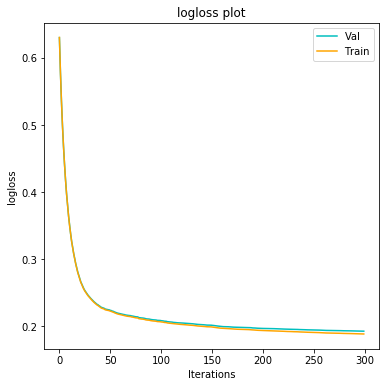

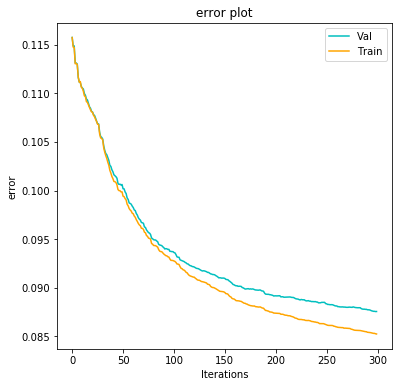

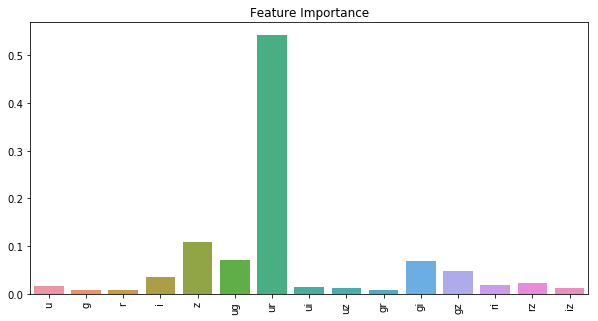

In [15]:
model_sdss = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.1,
                            max_depth=5, eval_metric='logloss', n_estimators=100,
                            seed=42, use_label_encoder=False)
# model_wise_gaia.fit(x_train_wise_gaia,y_train_wise_gaia)

fitXgb(model_sdss,x_train_sdss,y_train_sdss,x_test_sdss,y_test_sdss)

#### Printing the confusion matrix

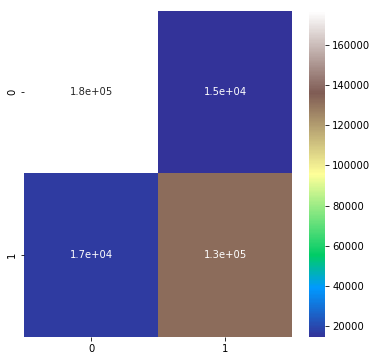

In [16]:
ypred_sdss=model_sdss.predict(x_test_sdss) 
cm_unbala=confusion_matrix(y_test_sdss,ypred_sdss)
sns.heatmap(cm_unbala, annot=True, cmap='terrain',fmt=".1e")

### Printing the dataframes of each class

In [17]:
star_sdss

,ra,dec,u,g,r,i,z,subClass,redshift,truth
0,100.769728,-0.325424,18.45337,15.58021,13.98747,15.31554,13.09262,K4Iab: (34255),0.000186,0
1,100.786432,-0.302304,15.99001,13.93058,12.63966,12.16869,12.75168,G9IV (100030),0.000193,0
2,100.810340,-0.437516,16.63020,15.51750,13.20474,14.64828,13.18433,K0IV (191026),0.000078,0
3,100.864191,-0.383563,17.77569,15.58206,14.46634,13.95121,13.61369,G5III+... (157910),0.000385,0
4,100.922152,-0.426890,18.49072,16.09097,15.95969,14.55682,13.53071,K3III (101673),0.000187,0
...,...,...,...,...,...,...,...,...,...,...
956005,357.930893,30.581747,25.42642,22.98405,21.66401,20.42070,19.75183,M4.5:III (123657),-0.000258,0
956006,357.950183,30.598270,25.63238,23.31310,21.56276,20.52892,19.70061,M5III (221615),-0.000164,0
956007,357.952191,30.644467,22.95718,23.12942,21.96715,20.27695,19.34297,M5III (221615),0.000021,0
956008,358.318728,30.480705,22.05286,21.99399,22.11093,22.24105,21.72409,WDmagnetic,0.002910,0


In [18]:
qso_sdss

,ra,dec,u,g,r,i,z,redshift,truth
0,81.299953,0.732651,19.31740,18.97724,18.28066,17.80950,17.57444,0.237931,1
1,80.796543,1.209814,24.63460,25.11435,24.80200,24.36178,17.74193,0.278063,1
2,245.090337,0.347051,18.60858,18.39430,17.97889,17.67771,17.41788,0.247249,1
3,241.356437,-1.175456,20.47630,20.08991,19.53681,19.22375,18.90528,0.250376,1
4,241.450077,-1.153629,20.78671,20.05316,18.85958,18.26720,17.94757,0.242751,1
...,...,...,...,...,...,...,...,...,...
751155,332.679283,31.172285,21.53817,21.45563,20.86644,20.66325,21.00396,5.735765,1
751156,357.467051,35.520048,21.85879,21.54774,21.23795,21.13664,20.56190,5.705946,1
751157,351.800219,34.467225,25.69218,23.58419,22.02843,20.95465,19.91640,5.739389,1
751158,0.262143,35.403995,26.71936,23.83496,22.01988,20.81997,19.95913,5.717356,1


In [19]:
gal_sdss

,Unnamed: 0,objid,ra,dec,u,g,r,i,z,class,redshift,subclass,l,b,truth
0,0,1.237650e+18,6.403310,-11.061283,20.34002,18.43994,17.31775,16.83446,16.45498,GALAXY,0.164221,NaN,100.988971,-72.823453,2
1,1,1.237650e+18,6.408608,-11.252825,19.23183,17.12976,16.08868,15.64556,15.29372,GALAXY,0.127127,NaN,100.783627,-73.005320,2
2,2,1.237650e+18,6.423094,-11.081480,19.57804,17.78292,17.06271,16.64686,16.39918,GALAXY,0.109746,STARFORMING,101.027705,-72.849031,2
3,3,1.237650e+18,6.473519,-11.089793,19.99005,18.23615,17.44422,17.12180,16.85892,GALAXY,0.109383,NaN,101.176275,-72.873545,2
4,4,1.237650e+18,6.553773,-11.196766,18.91357,17.61292,17.00917,16.64443,16.46111,GALAXY,0.081431,NaN,101.306877,-73.000725,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548979,2548979,1.237680e+18,351.607734,30.139517,22.79736,22.70983,20.88151,19.97876,19.63787,GALAXY,0.470937,NaN,101.879930,-29.233641,2
2548980,2548980,1.237680e+18,351.661222,30.088843,23.66809,21.66076,20.22141,19.12985,18.72010,GALAXY,0.497913,NaN,101.907763,-29.297822,2
2548981,2548981,1.237680e+18,351.713470,30.145913,25.94490,22.23045,20.71371,19.70183,19.12294,GALAXY,0.489250,NaN,101.980041,-29.261423,2
2548982,2548982,1.237680e+18,351.481899,30.449330,21.62544,20.09598,18.40002,17.75829,17.25439,GALAXY,0.261420,NaN,101.895644,-28.905616,2


In [86]:
features = ["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz"]
half=len(features)/2
half=int(half)
iterate_list=np.arange(0,len(features)-1).reshape(half,2)
iterate_list

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13]])

## Color - Color plots for visualizing the data

The accuracy is: 0.9062805695976381 and number of missclassified objects 31999 out of 341434
The accuracy is: 0.9062805695976381 and number of missclassified objects 31999 out of 341434
The accuracy is: 0.9062805695976381 and number of missclassified objects 31999 out of 341434
The accuracy is: 0.9062805695976381 and number of missclassified objects 31999 out of 341434


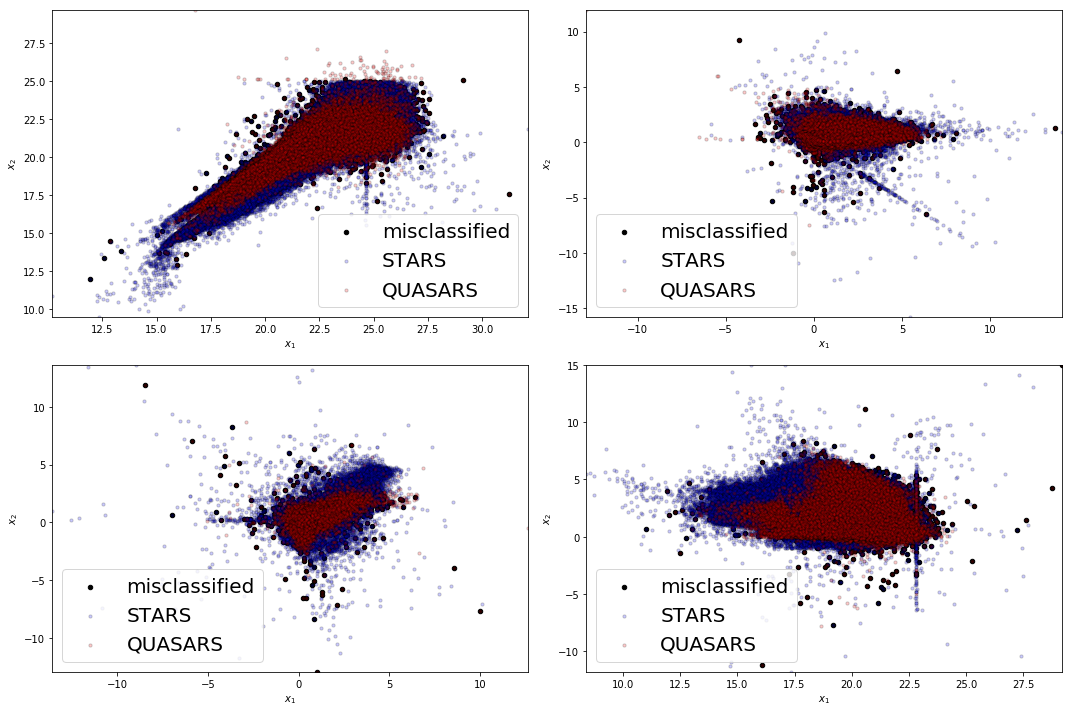

In [92]:
def SDSS_model_results(clf,X,y,ax, max_depth,feature1,feature2):
#     features= ["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz","W1mag","W2mag","W3mag","W4mag","W1W2","W1W3","W1W4","W2W3","W2W4",
#                          "W3W4","j","h","y","k","YJ","YH","YK","JH","JK"]
    features = ["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz"]
    ## initializing the decisionTreeclassifier with the max_depth hyperparameter being a variable that we can control
    ## by calling the function
    half=len(features)/2
    half=int(half)
    #clf = DecisionTreeClassifier(max_depth=max_depth)
    if len(features) % 2 ==0:   
        iterate_list=np.arange(0,len(features)).reshape(half,2)
    else:
        iterate_list=np.arange(0,len(features)-1).reshape(half,2)
    ## fitting the model on the X and y values
    X_bkg_list=[]
    xx1, yy1 = np.meshgrid(np.linspace(X[feature1].min(), X[feature1].max(), 300), 
                         np.linspace(X[feature2].min(), X[feature2].max(), 300))
    
    xxextra, yyextra = np.meshgrid(np.linspace(X["rz"].min(), X["rz"].max(), 300), 
                         np.linspace(X["iz"].min(), X["iz"].max(), 300))
    
    for i,j in iterate_list:
        xx, yy = np.meshgrid(np.linspace(X[features[i]].min(), X[features[i]].max(), 300), 
                         np.linspace(X[features[j]].min(), X[features[j]].max(), 300))
        X_bkg_list.append(xx.ravel())
        X_bkg_list.append(yy.ravel())
#     X_bkg = np.array(np.c_[X_bkg_list[0],X_bkg_list[1],X_bkg_list[2],X_bkg_list[3],X_bkg_list[4],X_bkg_list[5],X_bkg_list[6],X_bkg_list[7]
#                           ,X_bkg_list[8],X_bkg_list[9],X_bkg_list[10],X_bkg_list[11],X_bkg_list[12],X_bkg_list[13],
#                           X_bkg_list[14],X_bkg_list[15],X_bkg_list[16],X_bkg_list[17],X_bkg_list[18],X_bkg_list[19]
#                           ,X_bkg_list[20],X_bkg_list[21],X_bkg_list[22],X_bkg_list[23],X_bkg_list[24],
#                           X_bkg_list[25],X_bkg_list[26],X_bkg_list[27],X_bkg_list[28],X_bkg_list[29],
#                           X_bkg_list[30],X_bkg_list[31],X_bkg_list[32],X_bkg_list[33]])

    X_bkg = np.array(np.c_[X_bkg_list[0],X_bkg_list[1],X_bkg_list[2],X_bkg_list[3],X_bkg_list[4],X_bkg_list[5],X_bkg_list[6],X_bkg_list[7]
                            ,X_bkg_list[8],X_bkg_list[9],X_bkg_list[10],X_bkg_list[11],X_bkg_list[12],X_bkg_list[13], yyextra.ravel()])
    ycont =clf.predict(X_bkg).reshape(yy1.shape)
    
    ## Make predictions on the X values that the model trained on
    y_pred = clf.predict(X)
    # plot the classification results
    #ax.contourf(xx1, yy1, ycont, cmap='coolwarm', alpha=0.7) # coloured by class
    #ax.scatter(xx1[ycont==0], yy1[ycont==0], s=10,c = "b", marker="*", alpha=0.3) # coloured by class
    #ax.scatter(xx1[ycont==1], yy1[ycont==1], s=10,c = "r", marker="*", alpha=0.3) # coloured by class
    #ax.scatter(xx1[ycont==2], yy1[ycont==2], s=10,c = "r", marker="*", alpha=0.3) # coloured by class
    
    ax.scatter(X[feature1][y_pred!=y], X[feature2][y_pred!=y], s=20, c='black',label="misclassified")
    
    ax.scatter(X[feature1][y==0], X[feature2][y==0], s=10, facecolor='b',edgecolor="black",alpha=0.2,label="STARS")
    ax.scatter(X[feature1][y==1], X[feature2][y==1], s=10, facecolor='r',edgecolor="black",alpha=0.2, label="QUASARS")
    #ax.scatter(X[feature1][y==2], X[feature2][y==2], s=30, facecolor='r',edgecolor="black")

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_xlim(X[feature1].min(),X[feature1].max())
    ax.set_ylim(X[feature2].min(),X[feature2].max())
    plt.tight_layout()
    accuracy_sdss_wise_ukidss = accuracy_score(y,y_pred)  
    print("The accuracy is:",accuracy_sdss_wise_ukidss,"and number of missclassified objects", len(X[feature1][y!=y_pred]),"out of",len(X))
    ax.legend(fontsize=20);
    ## Printing the accuracy score of the trained model on the training data
    #print(f"Train accuracy for make moons noise={n} and tree max depth={max_depth}: {accuracy_score(y_pred, y.values)*100.0:.2f}%")

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
plt.rcParams.update({'figure.figsize':(15,10)})

SDSS_model_results(model_sdss,x_test_sdss,y_test_sdss,ax1,5,"u","g")
SDSS_model_results(model_sdss,x_test_sdss,y_test_sdss,ax2,5,"ug","gr")
SDSS_model_results(model_sdss,x_test_sdss,y_test_sdss,ax3,5,"gi","rz")
SDSS_model_results(model_sdss,x_test_sdss,y_test_sdss,ax4,5,"z","ur")

### Save the sdss model using pickle

In [71]:
filename = 'model_sdss_01_12_2022.sav'
pickle.dump(model_sdss, open(filename, 'wb'))

### Print analytic metrics report

In [72]:
print(metrics.classification_report(y_test_sdss,ypred_sdss, digits=3))

              precision    recall  f1-score   support

           0      0.911     0.923     0.917    191688
           1      0.900     0.885     0.892    149746

    accuracy                          0.906    341434
   macro avg      0.905     0.904     0.905    341434
weighted avg      0.906     0.906     0.906    341434

